# 🏃‍♂️ Exploratory Data Analysis (EDA)
**Project**: Preventing Injuries in Triathletes with Machine Learning using Wearable Sensor Data  
**Notebook**: 01 - Exploratory Data Analysis  
**Author**: Leonardo Rossi  

---

### 🔍 Objective:
To understand the structure, quality, and patterns in the synthetic dataset to guide preprocessing, feature engineering, and model development.


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict


sns.set(style="whitegrid")


# Load data
athletes = pd.read_csv("../simulated_data/athletes.csv")
activities = pd.read_csv("../simulated_data/activity_data.csv")
daily_data = pd.read_csv("../simulated_data/daily_data.csv")

## 📋 Data Overview
We explore the three core tables:
1. **Athlete Profiles** — Static data (age, gender, experience, lifestyle, performance metrics, ...)
2. **Daily Wearable Data** — Physiological signals (HRV, sleep, recovery, stress, ...)
3. **Daily Activity Data** — Training metrics (duration, intensity, sport specific metrics, ...)

In [70]:
# Check shapes and null values
for df, name in zip([athletes, daily_data, activities], ['athletes', 'daily_data', 'activities']):
    print(f"{name} → shape: {df.shape}, missing values:\n{df.isnull().sum()}\n")

athletes → shape: (1000, 26), missing values:
athlete_id                0
gender                    0
age                       0
height_cm                 0
weight_kg                 0
genetic_factor            0
hrv_baseline              0
hrv_range                 0
max_hr                    0
resting_hr                0
lthr                      0
hr_zones                  0
vo2max                    0
running_threshold_pace    0
ftp                       0
css                       0
training_experience       0
weekly_training_hours     0
recovery_rate             0
lifestyle                 0
sleep_time_norm           0
sleep_quality             0
nutrition_factor          0
stress_factor             0
smoking_factor            0
drinking_factor           0
dtype: int64

daily_data → shape: (366000, 15), missing values:
athlete_id              0
date                    0
resting_hr              0
hrv                     0
sleep_hours             0
deep_sleep              0
light_

## 🔗 Merging Data
To perform injury prediction, we will merge the datasets on:
- `athlete_id`
- `date` (for daily data)

We aim to create one row per athlete per day with all available features.

Before we can do this we should aggregate the activities, in order to only have one row per athlete per day.

In [71]:
# Make sure 'date' is a datetime object
activities['date'] = pd.to_datetime(activities['date'])

# Define column groups for better organization
duration_cols = ['duration_minutes', 'tss']
intensity_cols = ['intensity_factor']
distance_cols = ['distance_km', 'avg_speed_kph']
hr_cols = ['avg_hr', 'max_hr']
power_cols = ['avg_power', 'normalized_power', 'work_kilojoules']
elevation_cols = ['elevation_gain']

# All numeric columns for aggregation 
agg_columns = duration_cols + intensity_cols + distance_cols + hr_cols + power_cols + elevation_cols

# Fill missing values with 0
activities[agg_columns] = activities[agg_columns].fillna(0)

# Group by athlete_id, date, sport and aggregate numeric columns
grouped = activities.groupby(['athlete_id', 'date', 'sport'])[agg_columns].sum().reset_index()

# Pivot so each sport gets its own column prefix
pivoted = grouped.pivot_table(
    index=['athlete_id', 'date'],
    columns='sport',
    values=agg_columns,
    fill_value=0
)

# Custom function to reorder MultiIndex columns
def reorder_columns(df):
    # Get all sports
    sports = df.columns.levels[1].tolist()
    
    # Create new column order
    new_order = []
    
    # First add all duration columns grouped by sport
    for col in duration_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then add intensity columns
    for col in intensity_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then distance metrics
    for col in distance_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then heart rate metrics
    for col in hr_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then power metrics
    for col in power_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Finally elevation metrics
    for col in elevation_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Return reordered DataFrame
    return df[new_order]

# Reorder columns by category
pivoted_ordered = reorder_columns(pivoted)

# Flatten the columns but preserve logical grouping
# Transform ('duration_minutes', 'run') → 'run_duration_minutes' to keep sports together
pivoted_ordered.columns = [f"{sport}_{metric}" for metric, sport in pivoted_ordered.columns]

# Reset index for clean merging
pivoted_ordered.reset_index(inplace=True)

# Helper function to handle zones column, keeping as a dictionary
def aggregate_zone_dictionaries(series):
    # Initialize empty dictionary to store aggregated values
    aggregated = defaultdict(float)
    
    for item in series.dropna():
        # Parse string to dict if needed
        if isinstance(item, str):
            try:
                zones = ast.literal_eval(item)
            except:
                continue
        elif isinstance(item, dict):
            zones = item
        else:
            continue
            
        # Add values for each zone
        for zone, value in zones.items():
            aggregated[zone] += float(value)
            
    return dict(aggregated) if aggregated else None

# Group and aggregate zone data by athlete, date, and sport
zone_data = activities.groupby(['athlete_id', 'date', 'sport']).agg({
    'hr_zones': aggregate_zone_dictionaries,
    'power_zones': aggregate_zone_dictionaries
}).reset_index()

# Pivot to create sport-specific zone columns while keeping dictionary format
zone_pivoted = zone_data.pivot(
    index=['athlete_id', 'date'],
    columns='sport',
    values=['hr_zones', 'power_zones']
)

# Flatten and rename columns to 'sport_hr_zones' and 'sport_power_zones'
zone_pivoted.columns = [f"{sport}_{zone_type}" for zone_type, sport in zone_pivoted.columns]
zone_pivoted.reset_index(inplace=True)

# Merge numeric features with zone features
final_df = pivoted_ordered.merge(zone_pivoted, on=['athlete_id', 'date'], how='left')

# Reorganize final columns to ensure athlete_id and date come first
cols = final_df.columns.tolist()
id_date_cols = ['athlete_id', 'date']
other_cols = [col for col in cols if col not in id_date_cols]

# Custom sort for other columns to group by sport
sports = activities['sport'].unique().tolist()
sorted_cols = []

for sport in sports:
    # Add columns for this sport in order (duration first, then other metrics)
    sport_cols = [col for col in other_cols if col.startswith(f"{sport}_")]
    
    # Sort to ensure duration comes first, followed by zones and other metrics
    duration_sport_cols = [col for col in sport_cols if "duration" in col]
    zone_sport_cols = [col for col in sport_cols if "_zones" in col]
    other_sport_cols = [col for col in sport_cols if col not in duration_sport_cols + zone_sport_cols]
    
    sorted_cols.extend(duration_sport_cols + zone_sport_cols + other_sport_cols)

# Final column order
final_cols = id_date_cols + sorted_cols
final_activities_df = final_df[final_cols]

# Preview result
final_activities_df.head()

,athlete_id,date,bike_duration_minutes,bike_hr_zones,bike_power_zones,bike_tss,bike_intensity_factor,bike_distance_km,bike_avg_speed_kph,bike_avg_hr,...,strength_tss,strength_intensity_factor,strength_distance_km,strength_avg_speed_kph,strength_avg_hr,strength_max_hr,strength_avg_power,strength_normalized_power,strength_work_kilojoules,strength_elevation_gain
0,00176a66-e7e2-4e21-bfe4-68b79cfe8cd6,2024-01-01,0.0,NaN,NaN,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00176a66-e7e2-4e21-bfe4-68b79cfe8cd6,2024-01-02,52.0,"{'Z1': 13.461538461538462, 'Z2': 5.28846153846...","{'Z1': 13.461538461538462, 'Z2': 14.4230769230...",51.2,0.77,32.59,37.6,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00176a66-e7e2-4e21-bfe4-68b79cfe8cd6,2024-01-03,81.0,"{'Z1': 14.506172839506174, 'Z2': 19.4444444444...","{'Z1': 34.25925925925926, 'Z2': 65.74074074074...",54.0,0.63,46.04,34.1,154.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00176a66-e7e2-4e21-bfe4-68b79cfe8cd6,2024-01-04,0.0,NaN,NaN,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00176a66-e7e2-4e21-bfe4-68b79cfe8cd6,2024-01-06,0.0,NaN,NaN,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that the activities are aggregated we can preceed and merge the three tables.

In [72]:
# Make sure 'date' is a datetime object
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Merge daily + activity wearable device data
daily = pd.merge(daily_data, final_activities_df, on=['athlete_id', 'date'], how='inner')

# Add athlete profile data
merged = pd.merge(athletes, daily, on='athlete_id', how='left', suffixes=('_norm', '_daily'))

merged.head()


,athlete_id,gender,age,height_cm,weight_kg,genetic_factor,hrv_baseline,hrv_range,max_hr,resting_hr_norm,...,strength_tss,strength_intensity_factor,strength_distance_km,strength_avg_speed_kph,strength_avg_hr,strength_max_hr,strength_avg_power,strength_normalized_power,strength_work_kilojoules,strength_elevation_gain
0,f8173b91-1cd8-4abc-b235-b3126a2e0463,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f8173b91-1cd8-4abc-b235-b3126a2e0463,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f8173b91-1cd8-4abc-b235-b3126a2e0463,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f8173b91-1cd8-4abc-b235-b3126a2e0463,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f8173b91-1cd8-4abc-b235-b3126a2e0463,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 📋 Data Analysis

Now that we merged the three tables we can start exploring and understanding the data, by checking various relationships.
- let us start by seeing how rare injuries are. This informs us about class imbalances that need to be resolved later.

Injury Distribution:
injury
0    0.943105
1    0.056895
Name: proportion, dtype: float64


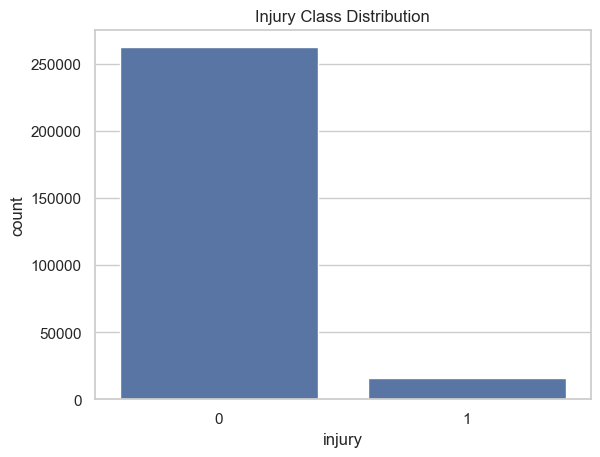

In [73]:
print("Injury Distribution:")
print(merged['injury'].value_counts(normalize=True))

sns.countplot(data=merged, x='injury')
plt.title("Injury Class Distribution")
plt.show()

As expected injuries are much rarer than non injuries and occur in 5.69 % of the cases. We have to address this in preprocessing to avoid bias.

In [74]:
# Summary stats
merged.describe()

,age,height_cm,weight_kg,genetic_factor,hrv_baseline,max_hr,resting_hr_norm,lthr,vo2max,running_threshold_pace,...,strength_tss,strength_intensity_factor,strength_distance_km,strength_avg_speed_kph,strength_avg_hr,strength_max_hr,strength_avg_power,strength_normalized_power,strength_work_kilojoules,strength_elevation_gain
count,278496.000000,278496.000000,278496.000000,278496.000000,278496.000000,278496.000000,278496.000000,278496.000000,278496.000000,278496.000000,...,278496.000000,278496.000000,278496.0,278496.0,278496.000000,278496.000000,278496.0,278496.0,278496.0,278496.0
mean,32.534302,171.875822,66.114646,0.996062,101.198547,187.571248,47.249611,184.305595,69.104239,3.928833,...,0.838420,0.033161,0.0,0.0,7.205777,9.519785,0.0,0.0,0.0,0.0
min,18.000000,147.000000,37.500000,0.800000,75.000000,167.500000,38.000000,160.000000,50.100000,3.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,29.000000,165.000000,56.500000,0.940000,94.500000,182.800000,43.500000,181.000000,66.100000,3.130000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,33.000000,172.000000,67.400000,1.000000,100.500000,187.600000,47.300000,188.000000,70.000000,3.770000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,37.000000,179.000000,75.100000,1.060000,106.500000,192.400000,50.700000,190.000000,75.000000,4.480000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
max,50.000000,200.000000,95.300000,1.200000,123.000000,217.900000,60.000000,190.000000,75.000000,5.500000,...,431.000000,0.840000,0.0,0.0,162.000000,207.000000,0.0,0.0,0.0,0.0
std,5.874828,9.388350,11.205931,0.088312,8.812242,6.897821,5.147077,7.652941,5.443031,0.832968,...,5.790481,0.143521,0.0,0.0,31.073901,41.047574,0.0,0.0,0.0,0.0


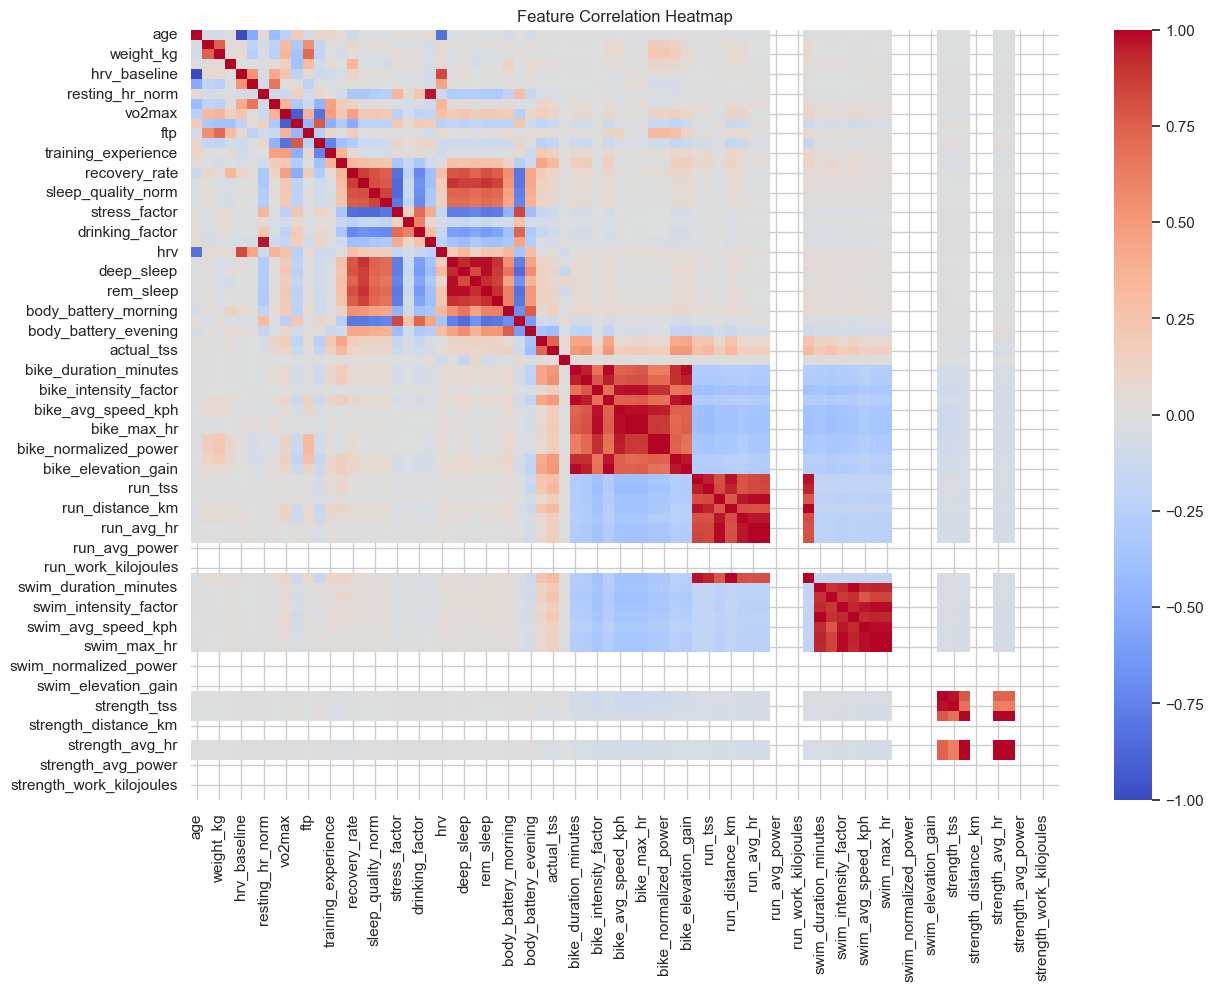

In [75]:
# Correlation heatmap (numerical features)
plt.figure(figsize=(14, 10))
sns.heatmap(merged.select_dtypes(include=np.number).corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

Let's see how HRV and Training load, known injury influencing factors, correspond with injury occurences.

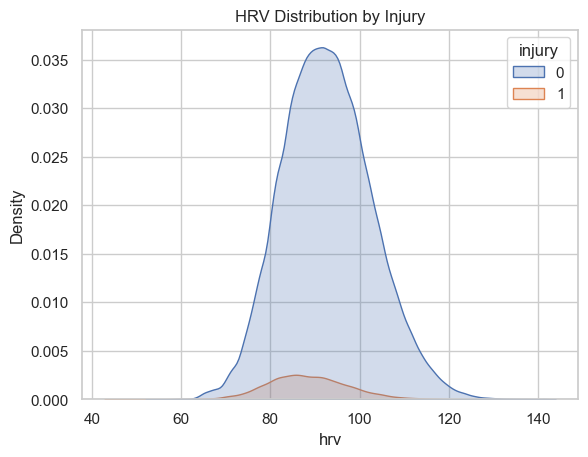

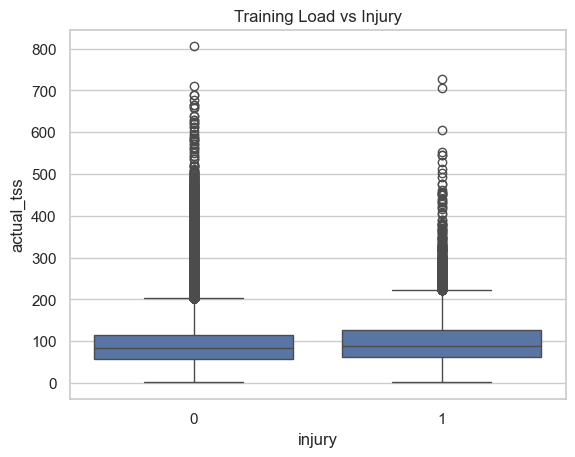

In [76]:
# HRV distribution for injured vs. not injured
sns.kdeplot(data=merged, x="hrv", hue="injury", fill=True)
plt.title("HRV Distribution by Injury")
plt.show()

# Boxplot of training load vs injury
sns.boxplot(data=merged, x="injury", y="actual_tss")
plt.title("Training Load vs Injury")
plt.show()

Okay, it is visible that the HRV on injury days tends to be lower than on non-injury days. No assumption can be made about training load. To make the relations more meanigful though, let us consider indivduals baselines HRV's and planned TSS compared to daily HRV and actual TSS.

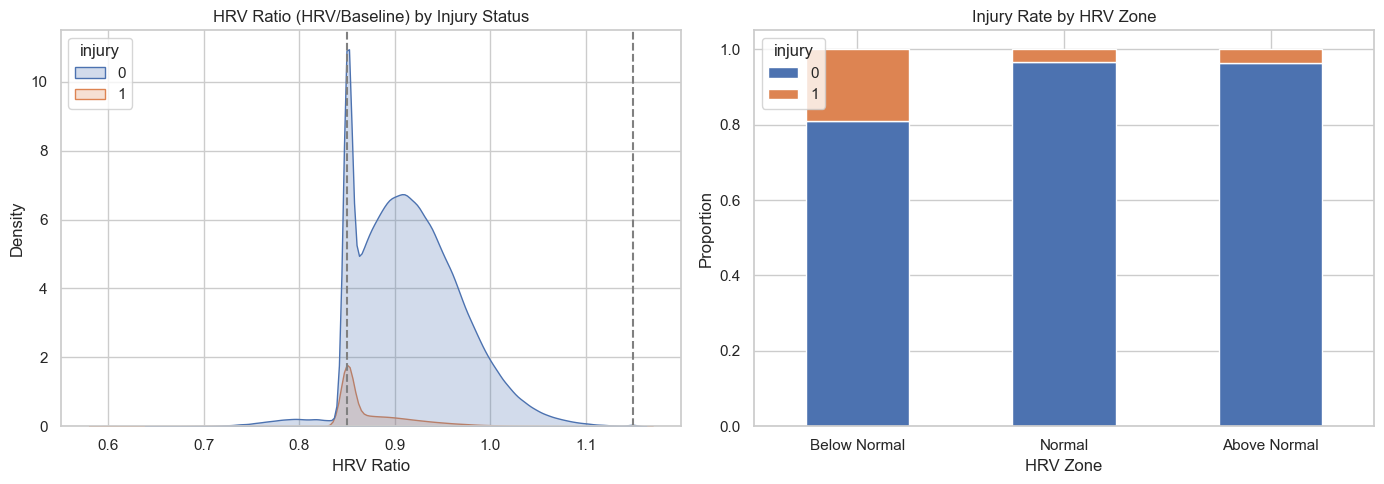

In [77]:
# Create HRV ratio to baseline
eda_copy = merged.copy()
eda_copy['hrv_ratio'] = eda_copy['hrv'] / eda_copy['hrv_baseline']

# Create HRV zone category
eda_copy['hrv_zone'] = pd.cut(
    eda_copy['hrv_ratio'], 
    bins=[0, 0.851, 1.15, float('inf')],
    labels=['Below Normal', 'Normal', 'Above Normal']
)

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: KDE of HRV ratio
sns.kdeplot(data=eda_copy, x="hrv_ratio", hue="injury", fill=True, ax=axs[0])
axs[0].axvline(x=0.85, color='gray', linestyle='--')
axs[0].axvline(x=1.15, color='gray', linestyle='--')
axs[0].set_title("HRV Ratio (HRV/Baseline) by Injury Status")
axs[0].set_xlabel("HRV Ratio")

# Right plot: HRV zones vs injury rate
injury_by_zone = pd.crosstab(
    eda_copy['hrv_zone'],
    eda_copy['injury'],
    normalize='index'
)

injury_by_zone.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title("Injury Rate by HRV Zone")
axs[1].set_ylabel("Proportion")
axs[1].set_xlabel("HRV Zone")
axs[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

Now it is clearly visible, that injuries are more likely when HRV is below normal (< 85% of baseline), in this HRV zone the injury occurence rate is 20%.

Now we want to quantify this observation:

In [78]:
# Set threshold
threshold = 0.851

# Count total cases per class
total_injuries = eda_copy[eda_copy['injury'] == 1].shape[0]
total_noninjuries = eda_copy[eda_copy['injury'] == 0].shape[0]

# Count how many fall below the threshold in each class
below_thresh_injuries = eda_copy[(eda_copy['injury'] == 1) & (eda_copy['hrv_ratio'] < threshold)].shape[0]
below_thresh_noninjuries = eda_copy[(eda_copy['injury'] == 0) & (eda_copy['hrv_ratio'] < threshold)].shape[0]

# Calculate proportions
injury_pct = below_thresh_injuries / total_injuries * 100
noninjury_pct = below_thresh_noninjuries / total_noninjuries * 100

# Print result
print(f"{injury_pct:.1f}% of injury cases had HRV < 85% of baseline.")
print(f"{noninjury_pct:.1f}% of non-injury cases had HRV < 85% of baseline.")

51.3% of injury cases had HRV < 85% of baseline.
13.1% of non-injury cases had HRV < 85% of baseline.


The observation is confirmed:
- 51.3% of injury cases had HRV < 85.1% of baseline.
- 13.1% of non-injury cases had HRV < 85.1% of baseline.

Now let's check TSS:

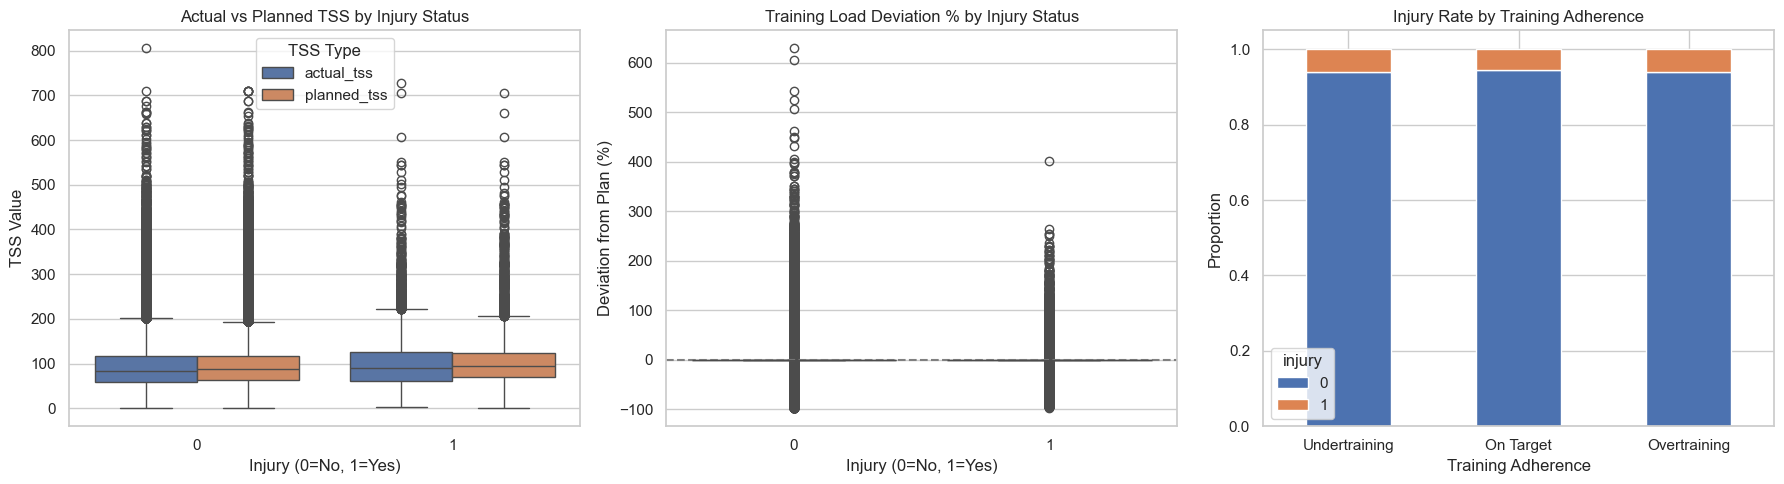

In [79]:
# Calculate the deviation from planned training
eda_copy['tss_deviation'] = eda_copy['actual_tss'] - eda_copy['planned_tss']
eda_copy['tss_deviation_pct'] = (eda_copy['tss_deviation'] / eda_copy['planned_tss']) * 100

# Create categories for training adherence
eda_copy['training_adherence'] = pd.cut(
    eda_copy['tss_deviation_pct'],
    bins=[-float('inf'), -15, 15, float('inf')],
    labels=['Undertraining', 'On Target', 'Overtraining']
)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Planned TSS by Injury Status
plot_data = eda_copy.melt(
    id_vars=['athlete_id', 'date', 'injury'], 
    value_vars=['actual_tss', 'planned_tss'],
    var_name='TSS Type', value_name='TSS Value'
)
sns.boxplot(data=plot_data, x='injury', y='TSS Value', hue='TSS Type', ax=axs[0])
axs[0].set_title("Actual vs Planned TSS by Injury Status")
axs[0].set_xlabel("Injury (0=No, 1=Yes)")

# Plot 2: Deviation % by Injury
sns.boxplot(data=eda_copy, x='injury', y='tss_deviation_pct', ax=axs[1])
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title("Training Load Deviation % by Injury Status")
axs[1].set_xlabel("Injury (0=No, 1=Yes)")
axs[1].set_ylabel("Deviation from Plan (%)")

# Plot 3: Training Adherence vs Injury Rate
adherence_injury = pd.crosstab(
    eda_copy['training_adherence'],
    eda_copy['injury'],
    normalize='index'
)

adherence_injury.plot(kind='bar', stacked=True, ax=axs[2])
axs[2].set_title("Injury Rate by Training Adherence")
axs[2].set_xlabel("Training Adherence")
axs[2].set_ylabel("Proportion")
axs[2].tick_params(axis='x', rotation=0)

# Tight layout
plt.tight_layout()
plt.show()

Weirdly no relationship can be identified. My hypothesis is that it is due to the fact that recovery days after an injury occured, where athletes likely do less than planned, are marked as injury days as well.
Let's try filtering to only keep the first day of each injury period and then re-plot.

Injury Distribution:
first_injury_day
False    0.988692
True     0.011308
Name: proportion, dtype: float64


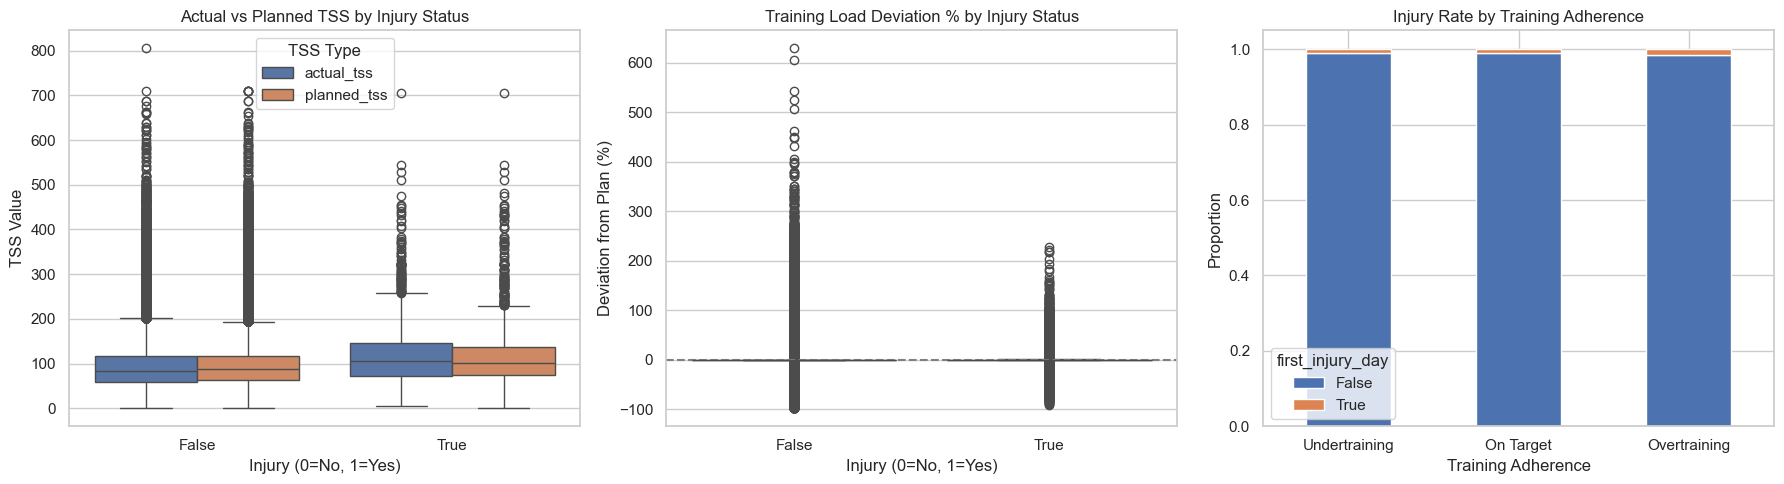

In [80]:
# Sort by athlete and date
eda_copy = eda_copy.sort_values(['athlete_id', 'date'])

# Identify first day of injury after a healthy day
eda_copy['prev_injury'] = eda_copy.groupby('athlete_id')['injury'].shift(1).fillna(0)
eda_copy['first_injury_day'] = (eda_copy['injury'] == 1) & (eda_copy['prev_injury'] == 0)

# Filter only the first injury days and all non-injury days
eda_filtered = eda_copy[(eda_copy['first_injury_day']) | (eda_copy['injury'] == 0)].copy()

# Set up 1 row, 3 columns layout
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Planned TSS by Injury Status
plot_data = eda_filtered.melt(
    id_vars=['athlete_id', 'date', 'first_injury_day'], 
    value_vars=['actual_tss', 'planned_tss'],
    var_name='TSS Type', value_name='TSS Value'
)
sns.boxplot(data=plot_data, x='first_injury_day', y='TSS Value', hue='TSS Type', ax=axs[0])
axs[0].set_title("Actual vs Planned TSS by Injury Status")
axs[0].set_xlabel("Injury (0=No, 1=Yes)")

# Plot 2: Training Load Deviation %
sns.boxplot(data=eda_filtered, x='first_injury_day', y='tss_deviation_pct', ax=axs[1])
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title("Training Load Deviation % by Injury Status")
axs[1].set_xlabel("Injury (0=No, 1=Yes)")
axs[1].set_ylabel("Deviation from Plan (%)")

# Plot 3: Training Adherence vs Injury Rate
adherence_injury = pd.crosstab(
    eda_filtered['training_adherence'],
    eda_filtered['first_injury_day'],
    normalize='index'
)

# Plot the bar chart on the third subplot
adherence_injury.plot(kind='bar', stacked=True, ax=axs[2], legend=True)
axs[2].set_title("Injury Rate by Training Adherence")
axs[2].set_xlabel("Training Adherence")
axs[2].set_ylabel("Proportion")
axs[2].tick_params(axis='x', rotation=0)

print("Injury Distribution:")
print(eda_filtered['first_injury_day'].value_counts(normalize=True))

# Finalize layout
plt.tight_layout()
plt.show()

Now it is alreadly slightly visible that first injury days overlap more commonly with overtraining days, than on target or undertraining days. It is only so slightly visible, as first injury days are even more rare with only approximately 1.1%. The under representation of injury occurences becomes even more evident and really needs to be addressed.

Now let's move a bit away and focus on the 7-day pre injury occurence window.

In [84]:
# First, identify injury dates for each athlete
injury_dates = eda_filtered[eda_filtered['first_injury_day'] == True][['athlete_id', 'date']].copy()
injury_dates['injury_date'] = injury_dates['date']

# For each athlete and each day in the dataset, find the closest future injury (if any)
merged_with_next_injury = eda_filtered.copy()

# Create a function to calculate days until next injury
def add_days_until_injury(athlete_data, athlete_injuries):
    if len(athlete_injuries) == 0:
        # No injuries for this athlete
        athlete_data['days_until_injury'] = -1
        athlete_data['is_pre_injury'] = False
        return athlete_data
    
    # For each row, find days until next injury
    athlete_data = athlete_data.sort_values('date')
    athlete_injuries = athlete_injuries.sort_values('injury_date')
    
    days_until = []
    is_pre_injury = []
    
    for idx, row in athlete_data.iterrows():
        # Find future injuries
        future_injuries = athlete_injuries[athlete_injuries['injury_date'] > row['date']]
        
        if len(future_injuries) == 0:
            # No future injuries
            days_until.append(-1)
            is_pre_injury.append(False)
        else:
            # Get days until next injury
            next_injury = future_injuries.iloc[0]['injury_date']
            days_diff = (next_injury - row['date']).days
            days_until.append(days_diff)
            # Mark as pre-injury if within 7 days before injury
            is_pre_injury.append(0 < days_diff <= 7)
    
    athlete_data['days_until_injury'] = days_until
    athlete_data['is_pre_injury'] = is_pre_injury
    return athlete_data

# Apply the function for each athlete
athlete_results = []

for athlete_id in eda_copy['athlete_id'].unique():
    athlete_data = eda_filtered[eda_filtered['athlete_id'] == athlete_id].copy()
    athlete_injuries = injury_dates[injury_dates['athlete_id'] == athlete_id]
    
    athlete_results.append(add_days_until_injury(athlete_data, athlete_injuries))

# Combine results
merged_with_timing = pd.concat(athlete_results)

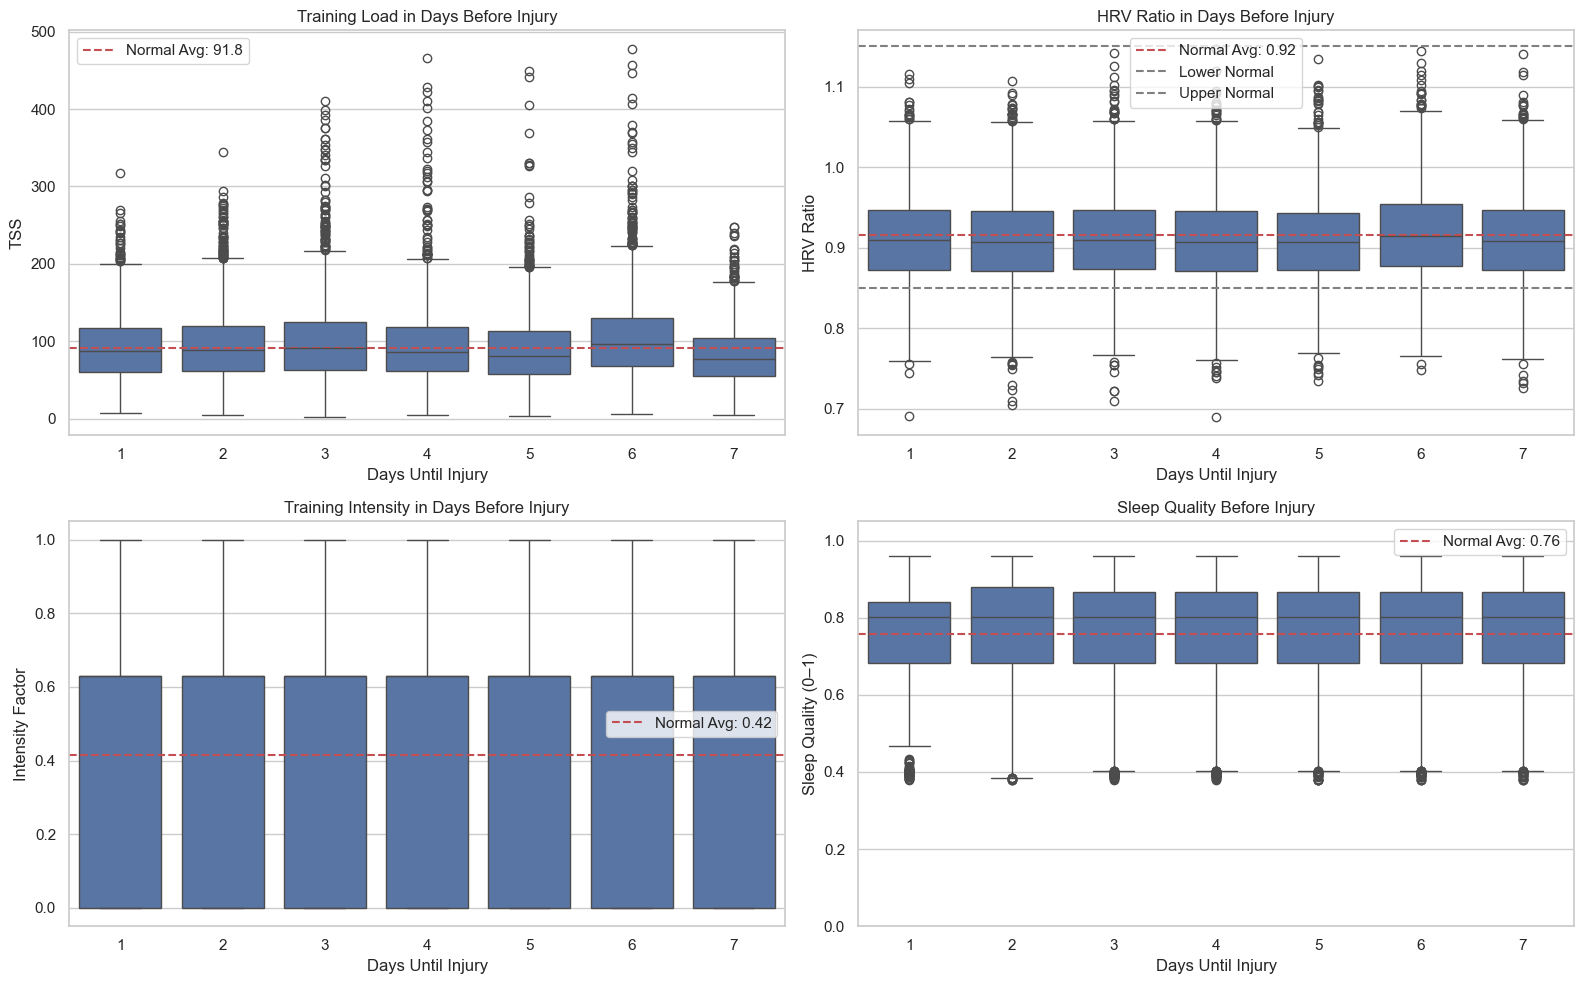

In [85]:
# Filter pre-injury and normal training days
pre_injury = merged_with_timing[merged_with_timing['is_pre_injury'] == True]
normal_training = merged_with_timing[(merged_with_timing['is_pre_injury'] == False) & 
                                     (merged_with_timing['injury'] == 0)]

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 1. TSS before injury
sns.boxplot(ax=axs[0, 0], x='days_until_injury', y='actual_tss',
            data=pre_injury[pre_injury['days_until_injury'] <= 7])
axs[0, 0].axhline(y=normal_training['actual_tss'].mean(), color='r', linestyle='--', 
                  label=f'Normal Avg: {normal_training["actual_tss"].mean():.1f}')
axs[0, 0].legend()
axs[0, 0].set_title('Training Load in Days Before Injury')
axs[0, 0].set_xlabel('Days Until Injury')
axs[0, 0].set_ylabel('TSS')

# 2. HRV Ratio before injury
sns.boxplot(ax=axs[0, 1], x='days_until_injury', y='hrv_ratio',
            data=pre_injury[pre_injury['days_until_injury'] <= 7])
axs[0, 1].axhline(y=normal_training['hrv_ratio'].mean(), color='r', linestyle='--',
                  label=f'Normal Avg: {normal_training["hrv_ratio"].mean():.2f}')
axs[0, 1].axhline(y=0.85, color='gray', linestyle='--', label='Lower Normal')
axs[0, 1].axhline(y=1.15, color='gray', linestyle='--', label='Upper Normal')
axs[0, 1].legend()
axs[0, 1].set_title('HRV Ratio in Days Before Injury')
axs[0, 1].set_xlabel('Days Until Injury')
axs[0, 1].set_ylabel('HRV Ratio')

# 3. Training intensity before injury
intensity_vars = [col for col in merged_with_timing.columns if 'intensity_factor' in col]
if intensity_vars:
    main_intensity = intensity_vars[0]
    sns.boxplot(ax=axs[1, 0], x='days_until_injury', y=main_intensity,
                data=pre_injury[pre_injury['days_until_injury'] <= 7])
    axs[1, 0].axhline(y=normal_training[main_intensity].mean(), color='r', linestyle='--',
                      label=f'Normal Avg: {normal_training[main_intensity].mean():.2f}')
    axs[1, 0].legend()
    axs[1, 0].set_title('Training Intensity in Days Before Injury')
    axs[1, 0].set_xlabel('Days Until Injury')
    axs[1, 0].set_ylabel('Intensity Factor')
else:
    axs[1, 0].text(0.5, 0.5, 'No intensity factor found.', ha='center', va='center')
    axs[1, 0].axis('off')

# 4. Sleep quality before injury (normalized between 0 and 1)
if 'sleep_quality_daily' in merged_with_timing.columns:
    sns.boxplot(
        ax=axs[1, 1], 
        x='days_until_injury', 
        y='sleep_quality_daily',
        data=pre_injury[pre_injury['days_until_injury'] <= 7]
    )
    axs[1, 1].axhline(
        y=normal_training['sleep_quality_daily'].mean(), 
        color='r', linestyle='--',
        label=f'Normal Avg: {normal_training["sleep_quality_daily"].mean():.2f}'
    )
    axs[1, 1].legend()
    axs[1, 1].set_title('Sleep Quality Before Injury')
    axs[1, 1].set_xlabel('Days Until Injury')
    axs[1, 1].set_ylabel('Sleep Quality (0–1)')
    axs[1, 1].set_ylim(0, 1.05)  # Limit y-axis to valid range
else:
    axs[1, 1].text(0.5, 0.5, 'Sleep quality data not available.', ha='center', va='center')
    axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Injury Risk Indicators – Observations from 7-day Pre-Injury windows

#### Training Load (TSS - Training Stress Score)
- Boxplots show TSS values increasing slightly around days 3–4, and peaking on day 6 before injury.
- Many outliers above the normal average of 91.8, suggesting excessive training load may precede injuries.
- Day 7 shows a decrease in TSS, potentially indicating fatigue-related performance reduction, or a rest day commonly falling 7 days pre injury

#### HRV Ratio
- Relatively stable across the week before injury.
- Normal average is 0.92, with defined upper (1.15) and lower (0.85) normal bounds.
- Most values fall within the normal range, but some outliers fall below 0.85, possibly indicating insufficient recovery.

#### Training Intensity
- Intensity remains fairly consistent throughout the week.
- Normal average is 0.42.
- No clear upward or downward trend leading to injury.

#### Sleep Quality
- Measured on a 0–1 scale, with a normal average of 0.76.
- Sleep quality is relatively consistent, though a few outliers drop to ~0.4, suggesting poor sleep may play a role in injury susceptibility.

### Summary Insight
Injuries might be preceded by:
- Above-average training loads, especially 3–6 days prior to the injury event.
- HRV values below the normal range, indicating possible insufficient recovery.
- Occasional poor sleep quality, which may contribute to increased injury risk.


HRV values are relatively within the normal range, which is odd given the observation we made before. So let's inspect this closer.

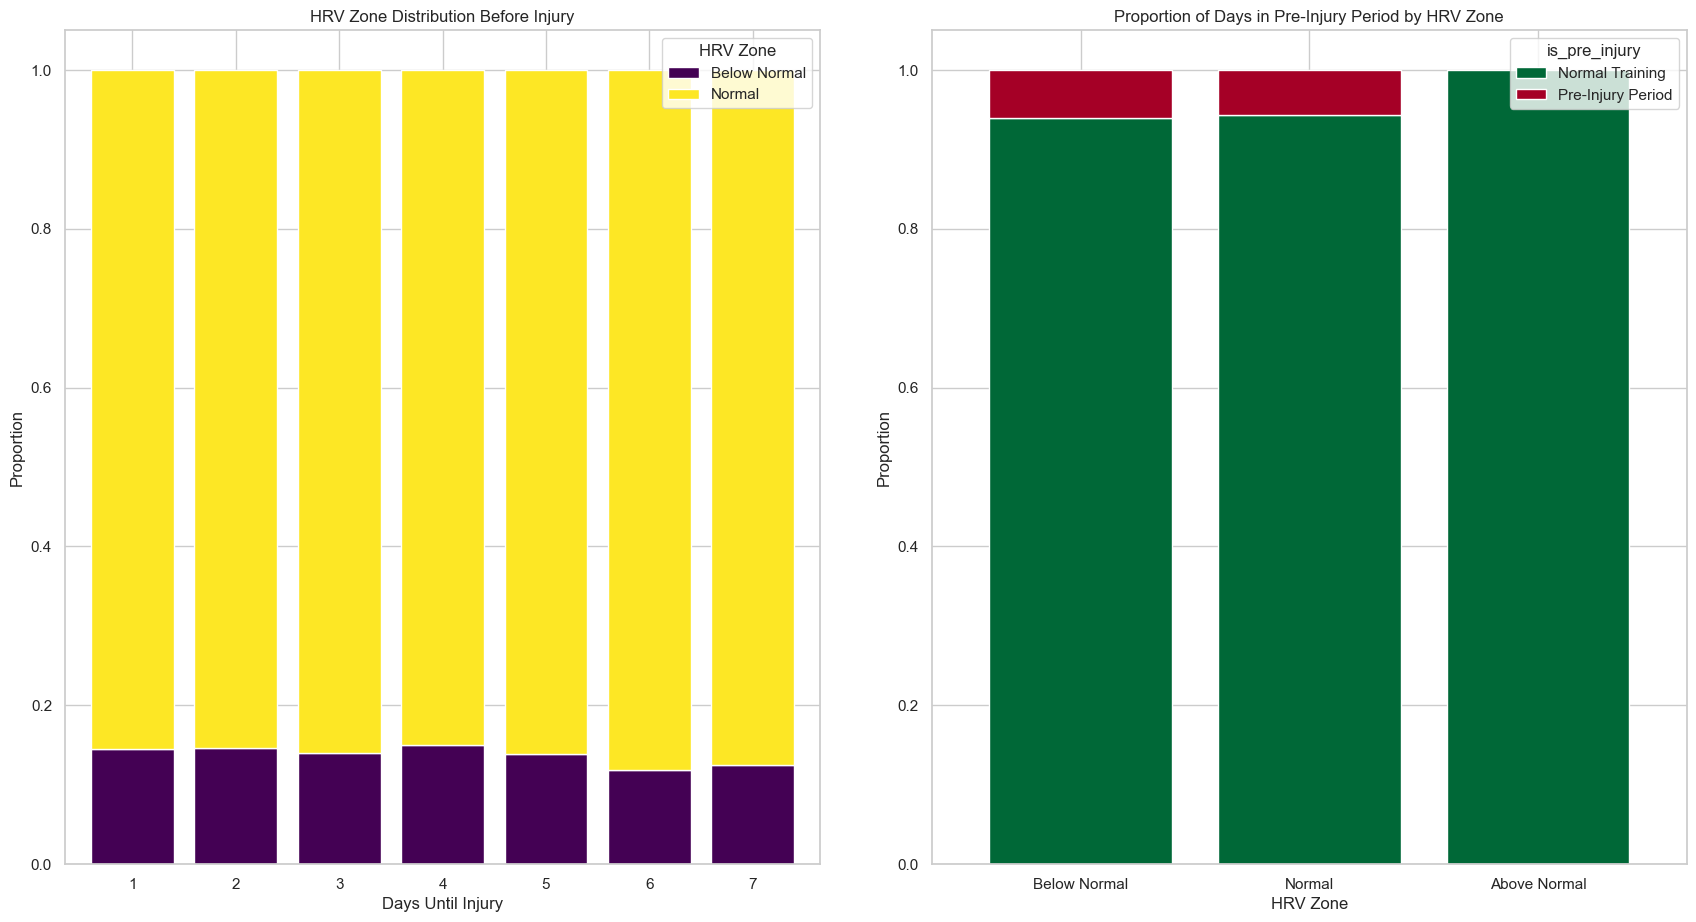

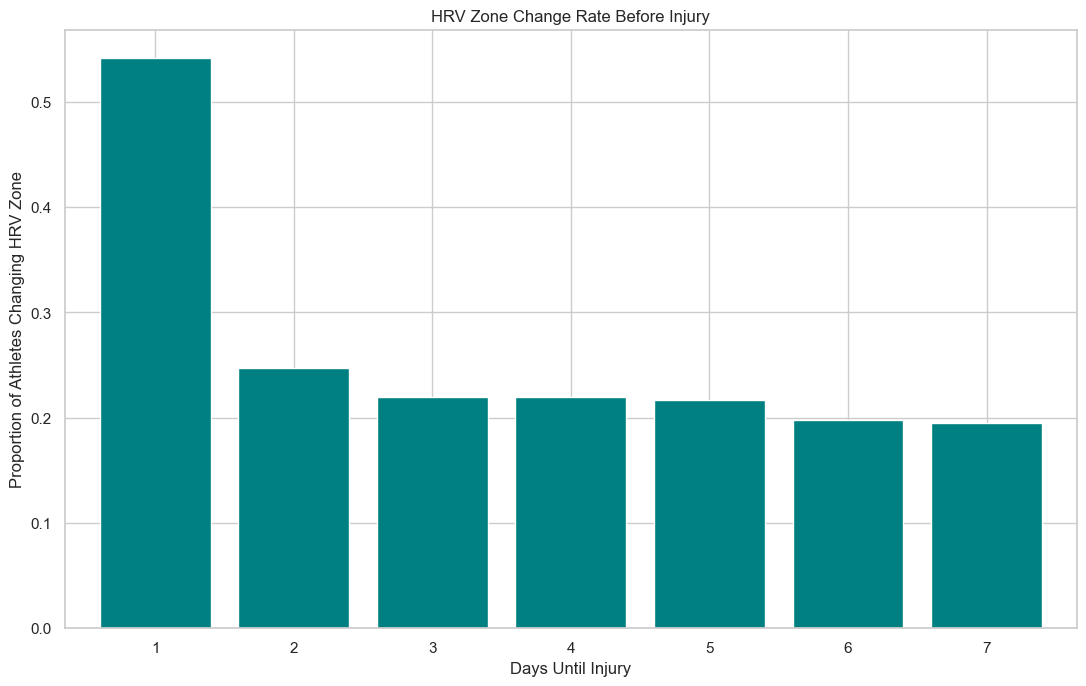

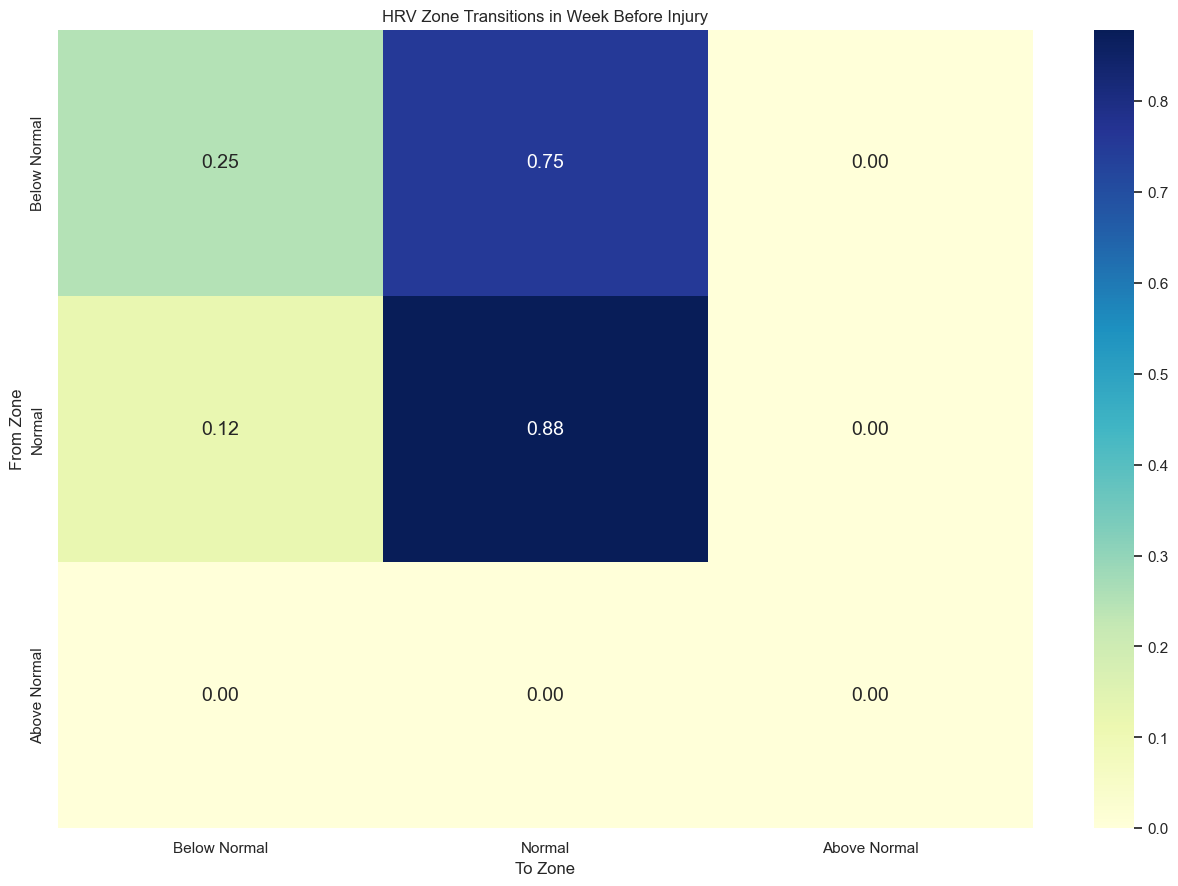

In [86]:
# Ensure HRV ratio is calculated if not present
if 'hrv_ratio' not in merged_with_timing.columns:
    merged_with_timing['hrv_ratio'] = merged_with_timing['hrv'] / merged_with_timing['hrv_baseline']

# Create HRV zone category
merged_with_timing['hrv_zone'] = pd.cut(
    merged_with_timing['hrv_ratio'], 
    bins=[0, 0.851, 1.15, float('inf')],
    labels=['Below Normal', 'Normal', 'Above Normal']
)

# 1. HRV zone distribution in days leading up to injury
fig, axes = plt.subplots(1, 2, figsize=(18, 10))  # Create two subplots
fig.tight_layout(pad=4.0)  # Adjust padding between subplots

# First subplot: HRV zone distribution before injury
pre_injury_hrv = pre_injury[pre_injury['days_until_injury'] <= 7]
hrv_zone_counts = pd.crosstab(pre_injury_hrv['days_until_injury'], pre_injury_hrv['hrv_zone'], normalize='index')
hrv_zone_counts.plot(kind='bar', stacked=True, colormap='viridis', width=0.8, ax=axes[0])  # Use ax[0] for the first subplot
axes[0].set_title('HRV Zone Distribution Before Injury')
axes[0].set_xlabel('Days Until Injury')
axes[0].set_ylabel('Proportion')
axes[0].legend(title='HRV Zone')
axes[0].set_xticks(range(len(hrv_zone_counts.index)))
axes[0].set_xticklabels(hrv_zone_counts.index, rotation=0)

# Second subplot: Injury rate by HRV zone
injury_by_hrv_zone = pd.crosstab(merged_with_timing['hrv_zone'], merged_with_timing['is_pre_injury'], normalize='index')
if True in injury_by_hrv_zone.columns:
    injury_by_hrv_zone = injury_by_hrv_zone.rename(columns={True: 'Pre-Injury Period', False: 'Normal Training'})
injury_by_hrv_zone.plot(kind='bar', stacked=True, colormap='RdYlGn_r', width=0.8, ax=axes[1])  # Use ax[1] for the second subplot
axes[1].set_title('Proportion of Days in Pre-Injury Period by HRV Zone')
axes[1].set_xlabel('HRV Zone')
axes[1].set_ylabel('Proportion')
axes[1].set_xticks(range(len(injury_by_hrv_zone.index)))
axes[1].set_xticklabels(injury_by_hrv_zone.index, rotation=0)

plt.show()

# 2. Additional analysis: Changes in HRV zone before injury
plt.figure(figsize=(12, 8))

if len(pre_injury_hrv) > 0:
    zone_transitions = pre_injury_hrv.sort_values(['athlete_id', 'days_until_injury'], ascending=[True, False])
    zone_transitions['prev_zone'] = zone_transitions.groupby('athlete_id')['hrv_zone'].shift(-1)
    zone_transitions['zone_change'] = (zone_transitions['hrv_zone'] != zone_transitions['prev_zone']).astype(int)
    zone_change_rates = zone_transitions.groupby('days_until_injury')['zone_change'].mean()
    zone_change_rates.plot(kind='bar', color='teal', width=0.8)
    plt.title('HRV Zone Change Rate Before Injury')
    plt.xlabel('Days Until Injury')
    plt.ylabel('Proportion of Athletes Changing HRV Zone')
    plt.xticks(rotation=0)

plt.tight_layout(pad=4.0)
plt.show()

# 3. HRV zone trajectory visualization
plt.figure(figsize=(14, 10))

if len(pre_injury_hrv) > 0:
    zone_mapping = {'Below Normal': 0, 'Normal': 1, 'Above Normal': 2}
    pre_injury_hrv['zone_numeric'] = pre_injury_hrv['hrv_zone'].map(zone_mapping)
    
    transitions = []
    for athlete in pre_injury_hrv['athlete_id'].unique():
        athlete_data = pre_injury_hrv[pre_injury_hrv['athlete_id'] == athlete].sort_values('days_until_injury', ascending=False)
        if len(athlete_data) >= 2:
            for i in range(len(athlete_data) - 1):
                from_zone = athlete_data.iloc[i]['zone_numeric']
                to_zone = athlete_data.iloc[i+1]['zone_numeric']
                transitions.append((from_zone, to_zone))
    
    transition_matrix = np.zeros((3, 3))
    for from_zone, to_zone in transitions:
        if not np.isnan(from_zone) and not np.isnan(to_zone):
            transition_matrix[int(from_zone)][int(to_zone)] += 1
    
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums, out=np.zeros_like(transition_matrix), where=row_sums != 0)
    
    sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=['Below Normal', 'Normal', 'Above Normal'],
                yticklabels=['Below Normal', 'Normal', 'Above Normal'],
                annot_kws={"size": 14})
    plt.title('HRV Zone Transitions in Week Before Injury')
    plt.xlabel('To Zone')
    plt.ylabel('From Zone')

plt.tight_layout(pad=4.0)
plt.show()

## HRV Zone Distribution Analysis

### Daily HRV Zone Distribution Before Injury:
- **Days 1-5**: ~13-14% below normal HRV
- **Days 6-7**: Decreased to ~10-11% below normal HRV
- **Insight**: Suggests a higher prevalence of sub-optimal recovery in the days 1-5 before injury.

### HRV Zone Proportion Comparison:
- **Below-normal HRV zone**: ~10% of days in the pre-injury period
- **Normal HRV zone**: ~10% of days in the pre-injury period
- **Above-normal HRV zone**: Shows negligible pre-injury days
- **Insight**: Indicates that above-normal HRV may be protective against injury risk.

## HRV Zone Transitions Analysis

### From Below Normal HRV:
- **25%** chance of remaining below normal
- **75%** chance of improving to normal
- **0%** chance of reaching above normal

### From Normal HRV:
- **12%** chance of declining to below normal
- **88%** chance of remaining normal
- **0%** chance of improving to above normal

### From Above Normal HRV:
- **No transition probabilities** shown (all 0%)
- **Insight**: Suggests either rarity or protective nature of this zone.


Given the following observation we made earlier, this still seems odd.
- 51.3% of injury cases had HRV < 85.1% of baseline.
- 13.1% of non-injury cases had HRV < 85.1% of baseline.


However this observation was made before filtering for only first injury days and only considered the injury days itself. So let's compare the HRV trends on all injury days against only first injury days.

In [88]:
# Set threshold
threshold = 0.851

# Count total cases per class
total_injuries = eda_copy[eda_copy['injury'] == 1].shape[0]
total_noninjuries = eda_filtered[eda_filtered['injury'] == 0].shape[0]
total_first_injuries = eda_filtered[eda_filtered['first_injury_day'] == True].shape[0]

# Count how many fall below the threshold in each class
below_thresh_injuries = eda_copy[(eda_copy['injury'] == 1) & (eda_copy['hrv_ratio'] < threshold)].shape[0]
below_thresh_first_injuries = eda_filtered[(eda_filtered['first_injury_day'] == True) & (eda_filtered['hrv_ratio'] < threshold)].shape[0]
below_thresh_noninjuries = eda_filtered[(eda_filtered['injury'] == 0) & (eda_filtered['hrv_ratio'] < threshold)].shape[0]

# Calculate proportions
injury_pct = below_thresh_injuries / total_injuries * 100
first_injury_pct = below_thresh_first_injuries / total_first_injuries * 100
noninjury_pct = below_thresh_noninjuries / total_noninjuries * 100

# Print result
print(f"{injury_pct:.1f}% of injury cases had HRV < 85% of baseline.")
print(f"{first_injury_pct:.1f}% of first injury day cases had HRV < 85% of baseline.")
print(f"{noninjury_pct:.1f}% of non-injury cases had HRV < 85% of baseline.")

51.3% of injury cases had HRV < 85% of baseline.
18.8% of first injury day cases had HRV < 85% of baseline.
13.1% of non-injury cases had HRV < 85% of baseline.


In fact only 18.8% of first injury days, while 51.3% of all injury days show an HRV below baseline. This shows that HRV might drop significantly after the injury occured.

This observation makes sense, as injuries cause stress and pain to the body which both depress HRV. However it suggest that HRV might have limited predictive power for injuries in this synthetic dataset.